# DQN on the example of the Gym Atari Pong environment

## Exercise

1. Solve the Gym Atari problem using DQN:
* Use only fully connected layers, leaving only one channel.
* Choose the number of episodes and other training parameters according to the computing power.

2. Parameter optimization:
* Experiment with different parameter values (discount coefficient gamma, learning rate alpha, ε for ε-greedy strategy).
* Plot the "Average total reward" as a function of parameters gamma, alpha, epsilon
* Determine the optimal parameter values that lead to the best training results.

## Installing and importing libraries and modules

In [ ]:
!apt-get update
!apt-get install -y cmake libopenmpi-dev python3-opengl ffmpeg
!pip install torch torchvision opencv-python numpy
!pip install "gymnasium[atari]"
!pip install autorom[accept-rom-license]

In [ ]:
# Setting up the Atari environment
import gymnasium as gym
import ale_py
gym.register_envs(ale_py)

# Library for working with neural networks
import torch

# Module for creating neural networks
import torch.nn as nn

# Module for optimizing neural networks
import torch.optim as optim

# Module with activation and loss functions
import torch.nn.functional as F

# Importing transformations from torchvision for augmentation and preprocessing of images when working with neural networks
import torchvision.transforms as T

# Supports backpropagation
from torch.autograd import Variable

# Library for working with arrays
import numpy as np

# Data structures for the playback buffer
from collections import deque, namedtuple

# Module for generating random numbers
import random

# Module for working with the file system
import os

# Module for encoding and decoding data
import base64
from base64 import b64encode

# Import the time module for working with time (e.g. delays or measuring execution time)
import time

# Import the PIL (Pillow) library for opening and processing images in various formats
from PIL import Image

# Import OpenCV (cv2) — a library for image processing and computer vision
import cv2

# Module for working with data streams
import io

# Library for working with images and video
import imageio

# Module for displaying HTML in Google Colab
from IPython.display import HTML

# Module for displaying video in Google Colab
from IPython import display as ipythondisplay

# Module for recording video
from gymnasium.wrappers import RecordVideo

# Library for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline

# Disable unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda


## Environmental research

In [ ]:
# Creating an instance of the Pong-v5 environment
env = gym.envs.make("ALE/Pong-v5", render_mode='rgb_array')

In [ ]:
# Let's check the number of states and actions
state_shape = env.observation_space.shape
n_action = env.action_space.n
print('The number of states (form):', state_shape)
print('The number of actions:', n_action)
print('Available actions:', env.unwrapped.get_action_meanings())

The number of states (form): (210, 160, 3)
The number of actions: 6
Available actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


(np.float64(-0.5), np.float64(159.5), np.float64(209.5), np.float64(-0.5))

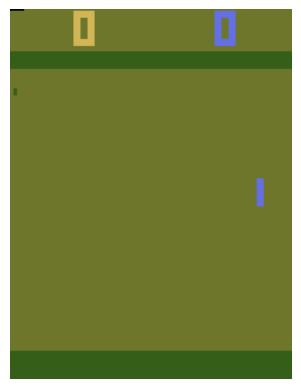

In [ ]:
# Display the environment
env.reset()
prev_screen = env.render()
plt.imshow(prev_screen)
plt.axis('off')

In this environment, the observation is an RGB image on the screen, which is a matrix. The matrix shape is (210, 160, 3), which corresponds to an image of size 210×160 with three RGB channels.

The agent (on the right) can move up and down and must hit the ball. If
it misses, the opponent (on the left) gets 1 point. If the opponent misses, the agent gets 1 point.

The first to get
21 points wins. The agent has six possible actions:
* 0: NOOP: the agent stands still;
* 1: FIRE: a forced hit action, the agent stays still;
* 2: RIGHT: the agent moves up;
* 3: LEFT: the agent moves down;
* 4: RIGHTFIRE: a forced hit and the agent moves up;
* 5: LEFTFIRE: Forced hit and agent moves down.

Each action is repeated for k frames (k can be 2, 3, 4, or 16 depending on the Pong environment variant).

The reward is calculated as follows:
* -1: agent missed the ball;
* 1: opponent missed the ball;
* 0: otherwise.

The observation space in Pong is 210 * 160 * 3. We will pre-reduce the image size to 84 * 84 while preserving color information.

## Step-by-step implementation of the DQN algorithm for the Pong environment

### 1. Define actions for the environment

In [ ]:
ACTIONS = [0, 2, 3] # 'NOOP', 'RIGHT', 'LEFT'
n_action = len(ACTIONS)

These are the following actions: stay in place, move up, move down.

### 2. Perform a random action

In [ ]:
# Reset the environment to its initial state before the episode starts
env.reset()

# Initialize a list for storing frames (images) of the scene (e.g. to save a video)
frames = []

# Infinite loop in which the agent interacts with the environment
while True:
    # Randomly select an action from the available actions
    action = ACTIONS[random.randint(0, n_action - 1)]

    # Perform an action in the environment and get a new observation, reward, and completion status
    obs, reward, done, truncated, _ = env.step(action)

    # Render the current state of the environment (visualize the current frame)
    prev_screen = env.render()

    # Add the current frame to the frames list for later processing or saving
    frames.append(prev_screen)

    # Check the condition for ending the episode (done — the goal is reached, truncated — time/steps are exceeded)
    if done or truncated:
        break

In [ ]:
path = './gym_animation.gif'
imageio.mimsave(path, frames, fps=30)

In [ ]:
def show_video(path):
    """
    Displays a GIF file in Google Colab
    @param path: path to file
    """
    video = io.open(path, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))


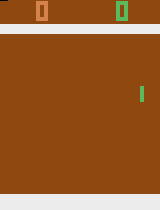

In [ ]:
show_video(path)

### 3. Let's define the function of reducing the image size and converting it into halftones

In [ ]:
# Frame preprocessing function
def preprocess_frame(frame):
    """
    Preprocesses the input frame for dimensionality reduction and normalization.
    @param frame (np.array): original RGB frame from Gym environment
    @param: np.array one-dimensional array (vector) with normalized gradation image (84x84 -> 7056)
    """
    # Convert the frame from RGB to grayscale (GRAY)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Resize the frame to 84x84 pixels to simplify processing by the neural network
    frame = cv2.resize(frame, (84, 84))

    # Normalize pixel values - divide by 255 to get values from 0 to 1
    frame = frame / 255.0

    # Convert the image to a one-dimensional array (vector) suitable for neural network
    return frame.astype(np.float32).ravel() # ravel() turns matrix into 1D array

### 4. Let's define the experience playback buffer

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

In [ ]:
class ReplayBuffer:
    """
    Class definition ReplayBuffer - An implementation of a replay buffer (experience store) used in reinforcement learning algorithms to store environment transitions.
    """
    def __init__(self, capacity=10000):
        """
        Initialize a buffer based on a deque, a double-ended queue.
        When capacity is exceeded, the oldest elements are automatically removed.
        @param capacity specifies the maximum number of elements to store.
        """
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        """
        Method for adding a new transition (state, action, reward, etc.) to the buffer.
        Transition is a namedtuple that combines the components of a single step (state, action, reward, next_state, done).
        """
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        """
        Method for random sampling from a batch_size transition buffer.
        random.sample — returns a list of unique elements of the specified size,
        randomly selected without repetitions.
        @param batch_size (int): batch size
        """
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        """
        Returns the current number of elements in the buffer.
        """
        return len(self.buffer)

### 5. Let's implement the DQN class for the Double DQN algorithm

We use only fully connected layers (MLP), leaving only one channel. This means that we need to take Linear (fully connected), and also make sure that the input tensor matches the requirements of the model.

In [ ]:
# Defines a DQN class, a deep neural network used to estimate Q-values of actions.
# Inherits from nn.Module, the PyTorch base class for neural networks.
class DQN(nn.Module):
    """
    A simple fully connected neural network for use in Deep Q-Network (DQN). Designed to estimate Q-values for each possible action given the current state of the environment.
    """
    def __init__(self, input_dim, n_action):
        """
        Initialization of neural network architecture.
        @param input_dim (int): input vector size (number of state features)
        @param n_action (int): number of possible actions (network outputs)
        """
        super(DQN, self).__init__()
        # Defining the sequence of network layers:
        # Input -> 256 neurons + ReLU -> 128 neurons + ReLU -> output (n_action)
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256), # First fully connected layer
            nn.ReLU(),                 # Activation function
            nn.Linear(256, 128),       # Second fully connected layer
            nn.ReLU(),                 # Activation function
            nn.Linear(128, n_action)   # Output layer: one output for each action
        )

    def forward(self, x):
        """
        Forward pass through the network.
        @param x (torch.Tensor): tensor with input data (environment state)
        @return torch.Tensor: tensor with Q-value estimates for each action
        """
        return self.net(x)

### 6. Hyperparameters

In [ ]:
# Input state dimension
input_dim = 84 * 84

# Mini-batch size
batch_size = 64

# Future reward discount factor (the closer to 1, the more future rewards are taken into account)
gamma = 0.99

# Initial epsilon value for ε-greedy strategy — probability of choosing a random action
epsilon_start = 1.0

# Final epsilon value — minimum probability of a random action (the agent almost always chooses the best action)
epsilon_final = 0.01

# Multiplier to decrease epsilon on each episode (exponential decay)
epsilon_decay = 0.99

# Learning rate for the optimizer (e.g. Adam)
learning_rate = 0.005

# Target network update frequency (update every target_update_freq steps or episodes)
target_update_freq = 10

# Total number of training episodes - how many times the full game/environment cycle will be run
num_episodes = 1000

### 7. Initialization of models

In [ ]:
# Create the main (policy) network - it will be used to select actions and learn from experience
policy_net = DQN(input_dim, n_action).to(device)

# Create the target network - it is used to stabilize the training,
# to prevent fluctuations in the calculation of target Q-values
target_net = DQN(input_dim, n_action).to(device)

# Initialize the target network weights with the same values as the policy network
target_net.load_state_dict(policy_net.state_dict())

# Switch the target network to evaluation mode, since we will not train it directly
target_net.eval()

# Adam optimizer to update the policy network parameters
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Initialize the Replay Buffer to store the environment transitions
# Needed for training on random mini-batches from past experience
memory = ReplayBuffer()

### 8. Let us define the ε-greedy strategy

In [ ]:
def select_action(state, epsilon):
    """
    Select an action from a limited list of ACTIONS using the ε-greedy strategy.
    """
    if random.random() < epsilon:
        # Exploration: randomly select from available actions
        return random.randint(0, n_action - 1)
    else:
        # Exploitation: use policy network to select the best action
        with torch.no_grad():
            q_values = policy_net(state).cpu().squeeze()
            # Take argmax only from actions in ACTIONS
            return q_values.argmax().item()

### 9. Education

In [ ]:
def optimize_model():
    """
    Trains policy_net (the main neural network) on a random sample from the replay buffer.
    Uses Double DQN for improved target estimation.
    """
    # Check if there is enough data in the buffer for training
    if len(memory) < batch_size:
        return # Exit if there is not enough data

    # Make a random sample from a buffer of size batch_size
    transitions = memory.sample(batch_size)

    # Convert the list of transitions into separate lists for state, action, reward, etc.
    # Transition is a namedtuple that combines the components of a single step
    batch = Transition(*zip(*transitions))

    # Convert batches to PyTorch tensors
    # Current states: combine all tensors into one common batch
    state_batch = torch.cat(batch.state)

    # Actions: convert to tensor and add dimension (unsqueeze)
    action_batch = torch.tensor(batch.action, device=device).unsqueeze(1)

    # Rewards: convert to tensor
    reward_batch = torch.tensor(batch.reward, device=device)

    # Done flag: convert to float32 for math operations
    done_batch = torch.tensor(batch.done, device=device, dtype=torch.float32)

    # Next states: filter and merge
    next_state_batch = torch.cat([s for s in batch.next_state])

    # Double DQN
    with torch.no_grad(): # Disable gradient calculation when calculating target values
        # Determine the best actions for the next states using policy_net
        next_actions = policy_net(next_state_batch).max(1)[1].unsqueeze(1)

        # Get Q-values for these actions using target_net
        next_state_values = target_net(next_state_batch).gather(1, next_actions).squeeze()

    # Calculate expected Q-values using Bellman's formula:
    # Q(s,a) = r + γ * (1 - done) * max(Q'(s',a))
    expected_q_values = reward_batch + gamma * (1 - done_batch) * next_state_values

    # Get predicted Q-values for selected actions from policy_net
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # Calculate the loss (error) between predicted and expected values
    loss = nn.MSELoss()(q_values, expected_q_values)

    # Zero out gradients before backpropagation
    optimizer.zero_grad()

    # Perform backpropagation (calculate gradients)
    loss.backward()

    # Update network weights
    optimizer.step()

### 10. Training

In [ ]:
# List for storing total rewards for each episode
episode_rewards = []

# Main loop for episodes
for i_episode in range(num_episodes):
    # Reset the environment at the beginning of each episode, get the initial state
    state = env.reset()[0]

    # Image preprocessing
    state = preprocess_frame(state)

    # Transform the state into a PyTorch tensor and add the batch dimension
    state = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0)

    # Initialize the total reward for the episode
    total_reward = 0

    # Flag for completing the current episode
    done = False

    # Loop inside one episode — until the environment returns done == True
    while not done:
        # Decrease epsilon over time (exponential decay)
        # But not below epsilon_final — to keep a little research
        epsilon = max(epsilon_final, epsilon_start * (epsilon_decay ** i_episode))

        # Select an action based on the current state and ε-greedy strategy
        action_idx = select_action(state, epsilon)

        # Get the actual action from the ACTIONS list
        action = ACTIONS[action_idx]

        # Perform the action in the environment and get a new transition
        next_state, reward, terminated, truncated, info = env.step(action)

        # Check if the episode has finished (due to game over or step limit)
        done = terminated or truncated

        # Preprocess the next state
        next_state = preprocess_frame(next_state)

        # Transform into a tensor and add the batch dimension
        next_state_tensor = torch.tensor(next_state, device=device, dtype=torch.float32).unsqueeze(0)

        # Add the received reward to the total for the episode
        total_reward += reward

        # Convert reward and done to tensors to store in the buffer
        reward_tensor = torch.tensor([reward], device=device)
        done_tensor = torch.tensor([done], device=device, dtype=torch.float32)

        # Save the transition (state, action, next_state, reward, done) to the playback buffer
        memory.push(state, action_idx, next_state_tensor, reward_tensor.item(), done_tensor.item())

        # Update the current state
        state = next_state_tensor

        # Train the model on a random mini-batch from the buffer
        optimize_model()

    # Save the total reward for the episode
    episode_rewards.append(total_reward)

    # Update target_net weights with a certain frequency
    if i_episode % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Output information about training progress
    print(f"Episode {i_episode+1}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

# Close the environment after all episodes are finished
env.close()

Episode 1, Total Reward: -21.00, Epsilon: 1.00
Episode 2, Total Reward: -21.00, Epsilon: 0.99
Episode 3, Total Reward: -19.00, Epsilon: 0.98
Episode 4, Total Reward: -20.00, Epsilon: 0.97
Episode 5, Total Reward: -19.00, Epsilon: 0.96
Episode 6, Total Reward: -18.00, Epsilon: 0.95
Episode 7, Total Reward: -21.00, Epsilon: 0.94
Episode 8, Total Reward: -20.00, Epsilon: 0.93
Episode 9, Total Reward: -20.00, Epsilon: 0.92
Episode 10, Total Reward: -21.00, Epsilon: 0.91
Episode 11, Total Reward: -21.00, Epsilon: 0.90
Episode 12, Total Reward: -21.00, Epsilon: 0.90
Episode 13, Total Reward: -19.00, Epsilon: 0.89
Episode 14, Total Reward: -21.00, Epsilon: 0.88
Episode 15, Total Reward: -21.00, Epsilon: 0.87
Episode 16, Total Reward: -19.00, Epsilon: 0.86
Episode 17, Total Reward: -19.00, Epsilon: 0.85
Episode 18, Total Reward: -21.00, Epsilon: 0.84
Episode 19, Total Reward: -21.00, Epsilon: 0.83
Episode 20, Total Reward: -21.00, Epsilon: 0.83
Episode 21, Total Reward: -21.00, Epsilon: 0.82
E

### 11. Let's plot a graph of the dependence of reward in an episode on time

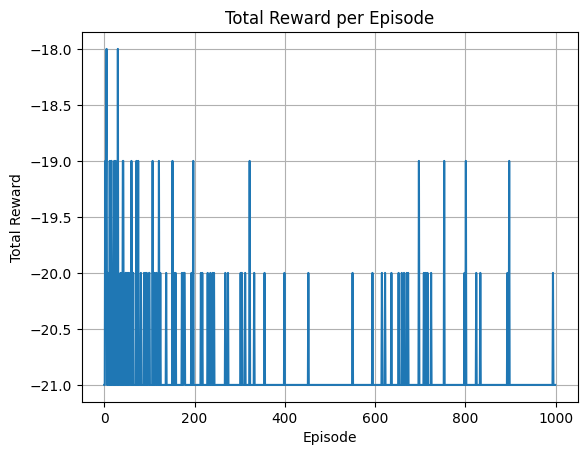

In [ ]:
# Plotting the total reward for each episode
plt.plot(episode_rewards)

# X-axis label is the episode number
plt.xlabel('Episode')

# Y-axis label is the total reward earned in this episode
plt.ylabel('Total Reward')

# Graph title
plt.title('Total Reward per Episode')

# Enabling a grid to make the graph easier to read
plt.grid(True)

# Displaying the graph on the screen
plt.show()

### 12. Let's display the graphs of the dependence of "Average total reward" on the parameters gamma, alpha, epsilon

Training function:

In [ ]:
def train_dqn(gamma=0.99, learning_rate=1e-3, epsilon_start=1.0, num_episodes=100):
    """
    Function to train an agent in Pong environment using DQN algorithm.
    @param gamma (float): discount rate for future rewards
    @param learning_rate (float): learning rate of optimizer
    @param epsilon_start (float): initial value of exploration probability
    @param num_episodes (int): number of training episodes
    @return avg_reward (float): average reward per episode
    """
    # Initialize the Gym 'Pong-v5' environment with the 'rgb_array' rendering mode
    env = gym.make("ALE/Pong-v5", render_mode='rgb_array')

    # Determine available actions (in Pong 0 - nothing, 2 - up, 3 - down)
    ACTIONS = [0, 2, 3]
    n_action = len(ACTIONS) # Number of possible actions

    # Input image size after processing: 84x84 pixels
    input_dim = 84 * 84

    # Create the main and target neural networks
    policy_net = DQN(input_dim, n_action).to(device)
    target_net = DQN(input_dim, n_action).to(device)

    # Load policy_net weights into target_net at startup
    target_net.load_state_dict(policy_net.state_dict())

    # Put the target network into evaluation mode (without updating gradients)
    target_net.eval()

    # Adam optimizer for updating policy_net weights
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

    # Replay buffer for storing transitions (state, action, next_state, reward, done)
    memory = ReplayBuffer()

    # Additional hyperparameters
    epsilon_final = 0.01 # Minimum epsilon value
    epsilon_decay = 0.995 # Epsilon decay factor
    target_update_freq = 10 # Target network update frequency

    # List for storing total rewards for each episode
    episode_rewards = []

    # Loop through training episodes
    for i_episode in range(num_episodes):
        # Reset the environment and get the initial state
        state = env.reset()[0]

        # Preprocess the current frame (e.g. grayscale, resize, normalize)
        state = preprocess_frame(state)

        # Convert to PyTorch tensor and add batch dimension
        state = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0)

        # Total reward for the episode
        total_reward = 0

        # Episode completion flag
        done = False

        # Loop inside one episode - until done == True
        while not done:
            # Decrease epsilon over time (exponential decay)
            epsilon = max(epsilon_final, epsilon_start * (epsilon_decay ** i_episode))

            # Select an action via the ε-greedy strategy
            action_idx = select_action(state, epsilon)
            action = ACTIONS[action_idx] # Get a real action from the list

            # Perform an action in the environment and get a new transition
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated # Check if the episode is finished

            # Preprocess the next state
            next_state = preprocess_frame(next_state)

            # Transform to a tensor and add the batch dimension
            next_state_tensor = torch.tensor(next_state, device=device, dtype=torch.float32).unsqueeze(0)

            # Add the received reward to the total
            total_reward += reward

            # Save the transition to the playback buffer
            memory.push(state, action_idx, next_state_tensor, reward, done)

            # Transition to the next state
            state = next_state_tensor

            # Train the model on a random mini-batch from the buffer
            optimize_model(policy_net, target_net, memory, optimizer, batch_size=64, gamma=gamma, n_action=n_action)

        # Store the total reward for the episode
        episode_rewards.append(total_reward)

        # Update the target network weights at a given frequency
        if i_episode % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

    # Close the environment after all episodes are finished
    env.close()

    # Calculate the average reward for all episodes
    avg_reward = np.mean(episode_rewards)

    return avg_reward

Additional functions:

In [ ]:
def optimize_model(policy_net, target_net, memory, optimizer, batch_size, gamma, n_action):
    """
    Trains a policy network on a random sample from the replay buffer.
    Uses Double DQN for more stable estimation of target Q-values.
    @param policy_net (nn.Module): main network to train
    @param target_net (nn.Module): target network to stabilize training
    @param memory (ReplayBuffer): replay buffer with environment transitions
    @param optimizer (torch.optim): optimizer to update network weights
    @param batch_size (int): mini-batch size
    @param gamma (float): discount factor for future rewards
    @param n_action (int): number of possible actions
    """
    # Check if there is enough data in the buffer for sampling
    if len(memory) < batch_size:
        return # If not, exit without training

    # Select a random batch of transitions from the buffer
    transitions = memory.sample(batch_size)

    # Transform the list of transitions into separate lists (state, action, reward, etc.)
    # Transition is a namedtuple that combines the components of one step
    batch = Transition(*zip(*transitions))

    # Form tensor batches for training
    # Current states: combine all tensors into one common batch
    state_batch = torch.cat(batch.state)

    # Actions: convert to a tensor and add a dimension (unsqueeze) for gather
    action_batch = torch.tensor(batch.action, device=device).unsqueeze(1)

    # Rewards: convert to a tensor
    reward_batch = torch.tensor(batch.reward, device=device)

    # Done flag: convert to float32 for math
    done_batch = torch.tensor(batch.done, device=device, dtype=torch.float32)

    # Next states: filter and merge
    next_state_batch = torch.cat([s for s in batch.next_state])

    # Double DQN
    with torch.no_grad(): # Disable gradient calculation when calculating target values
        # Determine best actions for next states using policy_net
        next_actions = policy_net(next_state_batch).max(1)[1].unsqueeze(1)

        # Get Q-values for these actions using target_net
        next_state_values = target_net(next_state_batch).gather(1, next_actions).squeeze()

    # Calculate expected Q-values using Bellman formula:
    # Q(s,a) = r + γ * (1 - done) * max(Q'(s',a))
    expected_q_values = reward_batch + (1 - done_batch) * gamma * next_state_values

    # Get predicted Q-values for selected actions from policy_net
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # Calculate loss (error) between predicted and expected values
    loss = nn.MSELoss()(q_values, expected_q_values)

    # Zero out gradients before backpropagation
    optimizer.zero_grad()

    # Perform backpropagation (calculate gradients)
    loss.backward()

    # Update network weights
    optimizer.step()

Function for plotting graphs:

In [ ]:
def run_experiments_and_plot(num_e=50):
    """
    Conducts a series of experiments with different hyperparameter values (gamma, learning rate, epsilon),
    trains the agent in the Pong environment and plots the average reward as a function of each parameter.
    @param num_e (int): number of episodes for each hyperparameter
    """
    # Define sets of values for testing:
    gammas = [0.9, 0.95, 0.99] # Different discount factors
    alphas = [5e-3, 1e-3, 1e-4] # Different learning rates
    epsilons = [1.0, 0.5, 0.1] # Different initial values of epsilon

    # Lists for storing results
    results_gamma = []
    results_alpha = []
    results_epsilon = []

    # Testing the influence of gamma (discount factor for future rewards)
    print("Testing gamma...")
    for g in gammas:
        print(f"gamma = {g}")
        avg_r = train_dqn(gamma=g, num_episodes=num_e)  # Train an agent with a fixed gamma
        results_gamma.append((g, avg_r)) # Store the pair (hyperparameter value, average reward)

    # Testing the impact of learning_rate
    print("Testing alpha...")
    for a in alphas:
        print(f"alpha = {a}")
        avg_r = train_dqn(learning_rate=a, num_episodes=num_e)
        results_alpha.append((a, avg_r))

    # Testing the Effect of Initial Epsilon (Exploratory Power)
    print("Testing epsilon...")
    for e in epsilons:
        print(f"epsilon = {e}")
        avg_r = train_dqn(epsilon_start=e, num_episodes=num_e)
        results_epsilon.append((e, avg_r))

    # Separate hyperparameter values and their corresponding average rewards
    x_g, y_g = zip(*results_gamma)
    x_a, y_a = zip(*results_alpha)
    x_e, y_e = zip(*results_epsilon)

    # Create a common figure for the three graphs
    plt.figure(figsize=(15, 5))

    # Graph 1: Average reward vs. gamma
    plt.subplot(1, 3, 1)
    plt.plot(x_g, y_g, 'o-') # 'o-' draws dots and lines between them
    plt.title("Average reward vs Gamma")
    plt.xlabel("Gamma") # Discount factor
    plt.ylabel("Average reward") # Average reward per episode

    # Graph 2: Average reward vs. learning rate
    plt.subplot(1, 3, 2)
    plt.plot(x_a, y_a, 'o-')
    plt.title("Average reward vs Learning Rate (Alpha)")
    plt.xlabel("Learning Rate (Alpha)") # Learning Rate
    plt.ylabel("Average reward")

    # Graph 3: Average reward vs initial epsilon
    plt.subplot(1, 3, 3)
    plt.plot(x_e, y_e, 'o-')
    plt.title("Average reward vs Epsilon")
    plt.xlabel("Epsilon") # Initial probability of random action
    plt.ylabel("Average reward")

    # Improving the layout of the graphs
    plt.tight_layout()

    # Displaying all graphs
    plt.show()

Testing gamma...
gamma = 0.9
gamma = 0.95
gamma = 0.99
Testing alpha...
alpha = 0.005
alpha = 0.001
alpha = 0.0001
Testing epsilon...
epsilon = 1.0
epsilon = 0.5
epsilon = 0.1


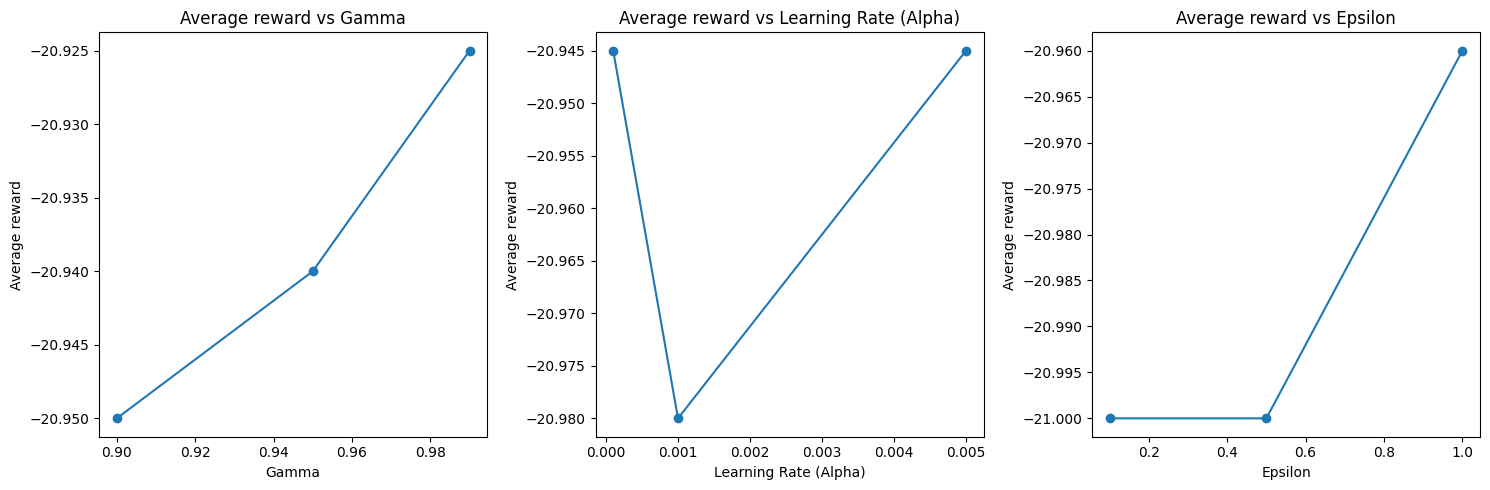

In [ ]:
# Launching experiments
run_experiments_and_plot(num_e=200)